In [3]:
using Plots, Optim, LinearAlgebra, LaTeXStrings, DataStructures

In [31]:
abstract type BoseHubbardModel end

struct MeanField <: BoseHubbardModel
    n_max :: Int64
    a :: Matrix{Float64}
    n :: Matrix{Float64}

    MeanField(n_max) = new(n_max, diagm(1 => sqrt.(1:n_max)), diagm(0 => 0:n_max))
end

expect(op, state) = (conj.(state') * op * state)[1]

function get_hamiltonian(model :: MeanField, t, mu, U, V, z, params)
    ψₐ, ψᵦ, ρₐ, ρᵦ = params
    H = -mu * model.n / (z * t) + (U/(2 * z * t)) * model.n * (model.n - I) + (V/t) * (ρᵦ * model.n - ρₐ * ρᵦ * I) - ψᵦ * (model.a + model.a') + ψₐ * ψᵦ * I
    return H 
end


function get_order_parameter(model, t, mu, U, V, z, init = nothing, depth = 1)
    ground_state((ψₐ, ψᵦ, ρₐ, ρᵦ)) = (eigvecs(get_hamiltonian(model, t, mu, U, V, z, [ψₐ, ψᵦ, ρₐ, ρᵦ]))[:, 1], eigvecs(get_hamiltonian(model, t, mu, U, V, z, [ψᵦ, ψₐ, ρᵦ, ρₐ]))[:, 1])
    
    init = isnothing(init) ? rand(0:100, 4) : init
    params = CircularBuffer{Vector{Float64}}(3)
    push!(params, init)

    tol = 4
    num_iter = 0

    while(true)
        psi_gs = ground_state(params[end])
        params_new = [abs(expect(model.a, psi_gs[1])), abs(expect(model.a, psi_gs[2])), expect(model.n, psi_gs[1]), expect(model.n, psi_gs[2])]
        push!(params, params_new)

        if((norm((params[end] .- params[end - 1])) <= 1/10^tol) || depth == 10) 
            return round.(params[end], digits = tol), depth
        end
        
        if(num_iter == 500) 
            if abs(params[1][3] - params[1][4]) <= 1/10^(tol - 1)
                if ((abs(params[1][3] - params[3][3]) <= 1/10^(tol - 1)) && (abs(params[1][3] - params[2][3]) >= 1/10^(tol - 1)))
                    res = get_order_parameter(model, t, mu, U, V, z, [params[1][1], params[2][2], params[1][3], params[2][4]], depth + 1)

                elseif abs(params[1][1] .- params[1][2]) <= 1/10^(tol - 1)
                    res = get_order_parameter(model, t, mu, U, V, z, [params[1][1], params[1][2], params[1][3], 0], depth + 1)
                else
                    res = get_order_parameter(model, t, mu, U, V, z, [(params[1][1] .+ params[1][2])/2, (params[1][1] .+ params[1][2])/2, params[1][3], params[1][4]], depth + 1)
                end
            else
                if abs(params[1][1] .- params[1][2]) <= 1/10^(tol - 1)
                    res = get_order_parameter(model, t, mu, U, V, z, [params[1][1], params[1][2], (params[1][3] + params[2][3])/2, (params[1][4] + params[2][4])/2], depth + 1)
                else
                    res = get_order_parameter(model, t, mu, U, V, z, (params[1] .+ params[2]) ./ 2, depth + 1)
                end
            end

            return res
        end

        num_iter += 1
    end

    return nothing
end


get_order_parameter (generic function with 3 methods)

In [50]:
model = MeanField(6)

z, num_points = 4, 50
U = range(start = 4, stop = 14, length = num_points)
mu = range(start = 0, stop = 5, length = num_points)
t = 1/4

order_param = zeros((num_points, num_points, 4))

for k1 in 1:num_points
    for k2 in 1:num_points
        tmp = (get_order_parameter(model, t, mu[k2], U[k1], 0.15 * U[k1], z))
        order_param[k2, k1, :] .= tmp[1]
        # if(tmp[2] == 10)
        #     println(t, ", ", mu[k2], ", ", U[k1], ", ", 0.15 * U[k1], ", ", z)
        # end
    end
end

In [39]:
function get_phases(params, tol)

    function identify(ψₐ, ψᵦ, ρₐ, ρᵦ, err = tol)
        c = 4 # default

        if isapprox(ψₐ, ψᵦ, atol = err)
            if isapprox(ψₐ, 0, atol = err)
                if isapprox(ρₐ, ρᵦ, atol = err)
                    c = 0 # MI
                else 
                    c = 1 # DW
                end
			elseif isapprox(ρₐ, ρᵦ, atol = err)
                c = 2 # SF
            end
		elseif !isapprox(ρₐ, ρᵦ, atol = err)
            c = 3 # SS
		end
        
        return c
    end
    return identify.(vcat([order_param[:, :, i] for i in 1:4])...)
end

get_phases (generic function with 2 methods)

In [40]:
i = 1
println(order_param[get_phases(order_param) .== 4, 1][i])
println(order_param[get_phases(order_param) .== 4, 2][i])
println(order_param[get_phases(order_param) .== 4, 3][i])
println(order_param[get_phases(order_param) .== 4, 4][i])

0.5058
0.5058
0.2983
0.2982


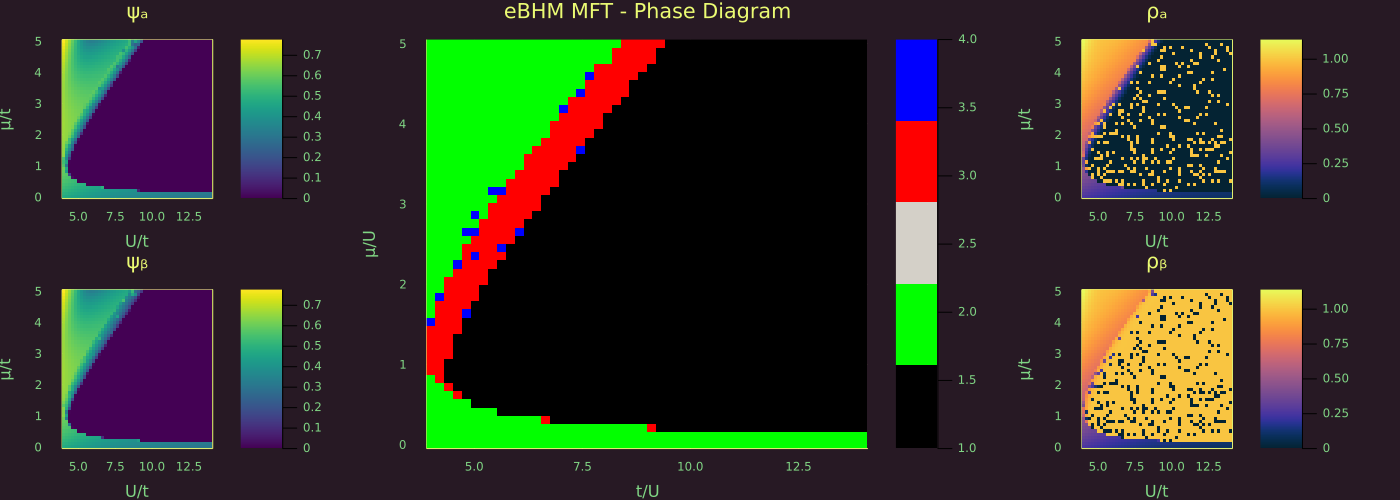

In [51]:
theme(:lime)
p = []
p_names = ["ψₐ", "ψᵦ", "ρₐ", "ρᵦ"]

for i in 1:4
    p_temp = (i <= 2) ? heatmap(U, mu, order_param[:, :, i]) : heatmap(U, mu, order_param[:, :, i], c = cgrad(:thermal, [1, 2, 3])) 
    plot!(
        ylabel = "μ/t",
        xlabel = "U/t",
        framestyle = :box, 
        title = p_names[i],
        margin = 5Plots.mm)

    push!(p, p_temp)
end

phases = heatmap(U, mu, get_phases(order_param, 1e-3), 
    c = palette([:black, "#02ff00", "#d4d0c8", "#ff0000", :blue]), 
    title = "eBHM MFT - Phase Diagram",
    ylabel = "μ/U",
    xlabel = "t/U",
    colorbar = true,
    colorbar_ticks = [0, 1, 2, 3, 4])

l = @layout [
    [grid(2, 1)] c{0.5w} [grid(2, 1)]
]
plot(p[1], p[2], phases, p[3], p[4], size = (1400, 500), layout = l)